In [96]:
from pathlib import Path
import json

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Ellipse
# import matplotlib.colors as colors
from matplotlib.lines import Line2D
plt.rcParams['svg.fonttype'] = 'none'
plt.style.use('seaborn-ticks')  # 'seaborn-ticks'
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import dateutil
import seaborn as sns

In [2]:
animals_used = [1091, 1093, 1060, 1062, 1074, 1092, 1102, 1076, 1082, 1101]
diabetic =     [1076, 1082, 1101]
impaired =     [1060, 1062, 1074, 1092, 1102]
normal =       [1091, 1093]
animal_tol = {
    1076: 'diabetic', 1082: 'diabetic', 1101: 'diabetic', 1060: 'impaired', 1062: 'impaired', 
    1074: 'impaired', 1092: 'impaired', 1102: 'impaired', 1091: 'normal', 1093: 'normal'}

ap = pd.read_excel(r'..\data\metadata\animal_phenotypes.xlsx', index_col=0)

fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)

# Use data that was sent to collaborators 
data = pd.read_excel(r'../data/processed/combined_metabolites_data.xlsx').set_index('i')
data_cols = data.filter(regex='FBG|RBG').columns
fbg_cols = data.filter(regex='FBG').columns
rbg_cols = data.filter(regex='RBG').columns
pval_cols = data.filter(regex='pval').columns

n = data.filter(regex='1091|1093')                 # normal
i = data.filter(regex='1060|1062|1074|1092|1102')  # impaired
d = data.filter(regex='1076|1082|1101')            # diabetic

f = data[fbg_cols]  # fasted
r = data[rbg_cols]  # random-fed

fn = n.filter(fbg_cols)  # fasted normal 
fi = i.filter(fbg_cols)  # fasted impaired
fd = d.filter(fbg_cols)  # fasted diabetic

rn = n.filter(rbg_cols)  # random normal
ri = i.filter(rbg_cols)  # random impaired
rd = d.filter(rbg_cols)  # random diabetic

order_cols = rn.columns.to_list() + fn.columns.to_list() + \
                ri.columns.to_list() + fi.columns.to_list() + \
                rd.columns.to_list() + fd.columns.to_list()

In [93]:
# colors
with open(r'..\data\metadata\color_schemes.json') as infile:
    colors = json.load(infile)
    
with open(r'..\data\metadata\extra color maps\metab_lipid_class_superclass_color.json', 'r') as infile:
    class_map = json.load(infile)

In [4]:
# feature_indexes = {i: int(col) for i, col in enumerate(df.columns)}
# raw_data = df.filter(regex='HILIC_T', axis=0)

groups = fg[['animal', 'week', 'bg_type', 'gluc_tol']]
# groups = groups.set_index('combined_col_name')
# display(groups)

raw_data = pd.merge(data.T, groups, how='inner',
                    left_on=data.T.index, right_on=groups.index).set_index('key_0')
pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA())])  # Scaling is essential for PCA
pca_data = pipeline.fit_transform(raw_data.filter(regex='m_|l_'))  # 2**raw gives the original untransformed data ###
# print(pca_data.shape)
# display(pca_data)
pca_object = pipeline.steps[1][1]
columns = ['pc' + str(x) for x in range(1, pca_data.shape[1] + 1)]
# print(columns)
pca_data = pd.DataFrame(pca_data, columns=columns)
# display(pca_data)
pca_data.index = raw_data.index
# display(pca_data)
pca_data = pd.concat([pca_data, raw_data[['animal', 'week', 'bg_type', 'gluc_tol']]], axis=1)
# display(pca_data)

## Loadings:

In [5]:
loadings = pd.DataFrame(pca_object.components_.T * np.sqrt(pca_object.explained_variance_))
# loadings = loadings.sort_values(0, ascending=False)
# plt.bar(np.arange(loadings.shape[1]), loadings[:, 0])

loadings.set_index(data.index).to_csv(r'..\data\processed\PCA_loadings.csv')

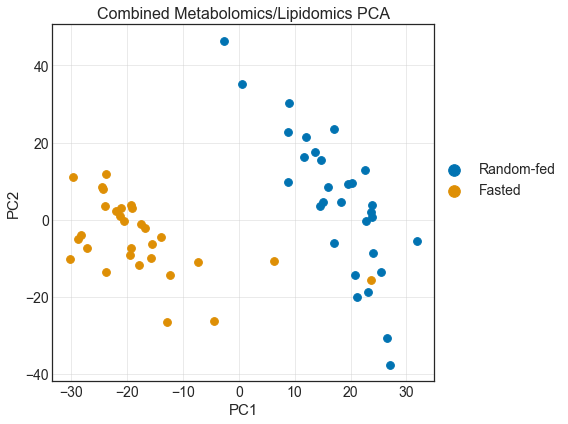

In [6]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('PC1', fontsize=15)
ax.set_ylabel('PC2', fontsize=15)
ax.set_title('Combined Metabolomics/Lipidomics PCA', fontsize=16)

targets = ['RBG', 'FBG']
weeks = [8, 9, 10]
target_colors = ['blue', 'orange']
markers = ['o', 's']
# colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
#           'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

for target, color in zip(['RBG', 'FBG'], target_colors):
    points = pca_data.loc[pca_data['bg_type'] == target]
    ax.scatter(points['pc1'], points['pc2'],
               color=colors[target], cmap='viridis', s=60)
ax.legend(['Random-fed', 'Fasted'], loc=(1, 0.5), fontsize=14, markerscale=1.5)
ax.grid(alpha=0.5)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# ax.text(-0.08, 1.03, "A", transform=ax.transAxes, fontsize=25, weight='bold')

plt.tight_layout()
# plt.savefig(r'..\reports\figures\3-5-1\RvF_PCA.svg', bbox_inches='tight')
# plt.savefig(r'..\reports\figures\3-5-1\RvF_PCA.png', bbox_inches='tight')

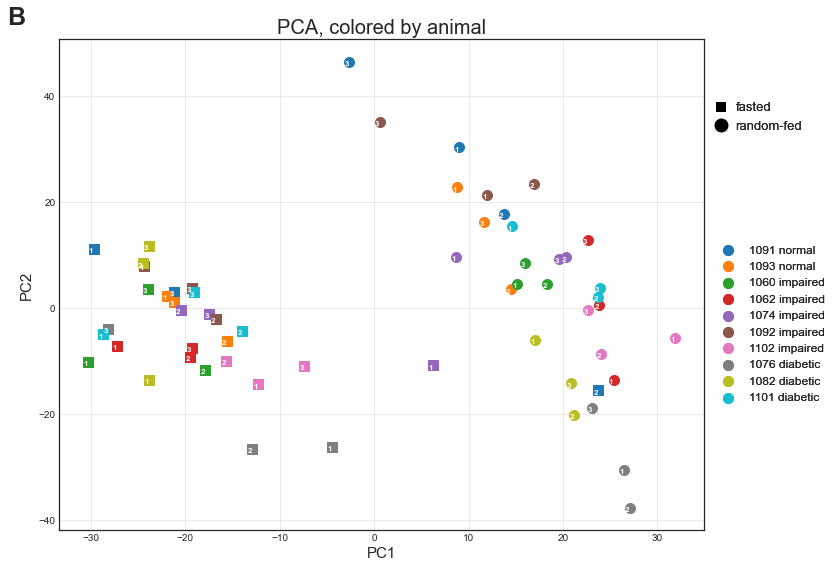

In [7]:
fig = plt.figure(figsize = (8,8))
fig.set_size_inches(10, 8)
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC1', fontsize = 15)
ax.set_ylabel('PC2', fontsize = 15)
ax.set_title('PCA, colored by animal', fontsize = 20)
targets = ['RBG', 'FBG']
weeks = [8, 9, 10]
markers = ['o', 's']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
          'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
# colors = [plt.get_cmap('Dark2')(i) for i in range(1, 11)]

handles = []

for target, marker in zip(targets, markers):
    for label, color in zip(animals_used, colors):
        scatter_points = pca_data[(pca_data['bg_type'] == target) & \
                                  (pca_data['animal'] == label)]
#             print(scatter_points)
        handle = ax.scatter(scatter_points['pc1'],
                            scatter_points['pc2'],
                            c = color,
#                             cmap='viridis',
                            marker=marker,
                            s = (110 if marker == 's' else 100))

#         Annotate the plot with number for week 8, 9, 10 (convert to 1, 2, 3 for ease of reading)
        for index, row in scatter_points.iterrows():
            week = row['week'] - 7  # Minus 7 to go from week 8->1, 9->2, 10->3
            ax.annotate(str(week), xy=(row['pc1']-0.5, row['pc2']-0.7), 
                        fontsize=8, color='white', weight='bold')

        # define the text label for the data handle for the legend:
        gluc_tol = ap[ap.index == label]['glucose_tolerance'].values[0]
        handle.set_label(str(label) + ' ' + gluc_tol)
        handles.append(handle)
        
# ax.legend(['RBG sample', 'FBG sample'],)
ax.grid(alpha=0.5)
plt.tight_layout()

legend_labels = []
for animal in animals_used:
    animal_data = ap[ap.index == animal]
    gluc_tol = animal_data['glucose_tolerance'].values[0]
    label = str(animal) + ' ' + gluc_tol
    legend_labels.append(label)
    
# Sort legend_labels based on normal/impaired/diabetic substring
# legend_labels.sort(key = lambda x: x.split(' ')[1])

handles, labels = ax.get_legend_handles_labels()

# print(handles, labels)
# legend = ax.legend(handles, labels, loc=(1.01, 0.23))

legend = ax.legend(handles[:10], labels[:10], loc=(1.01, 0.25), fontsize=12)

# legend = ax.legend(labels=legend_labels, loc=(1.01, 0.7))

legend2 = ax.legend(handles=[mpatches.Rectangle(xy=(0, 0), width=1, height=1, color='black', label='fasted', ),
                             Line2D([0], [0], marker='o', color='white', label='random-fed', 
                                    markerfacecolor='black', markersize=15)], 
                    loc=(1.01, 0.8), 
                    fontsize=13, 
                    handlelength=0.7)
ax.add_artist(legend)
ax.add_artist(legend2)

# legend = ax.legend(labels=legend_labels, loc=(1.01, 0.7))
ax.add_artist(legend)
# ax.legend(handles=[mpatches.Rectangle(xy=(0, 0), width=1, height=1, color='black', label='FBG'),
#                    mpatches.Circle(xy=(0, 0), color='black', label='RBG')])

ax.text(-0.08, 1.03, "B", transform=ax.transAxes, fontsize=25, weight='bold')
# ax.text(1.072, 0.87, "Animal, feeding, glucose tolerance", transform=ax.transAxes, fontsize=9)

plt.tight_layout()

C:\Users\bjanderson23\anaconda3\lib\site-packages\ipykernel_launcher.py:28: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


Text(0, 0.5, 'PC2')

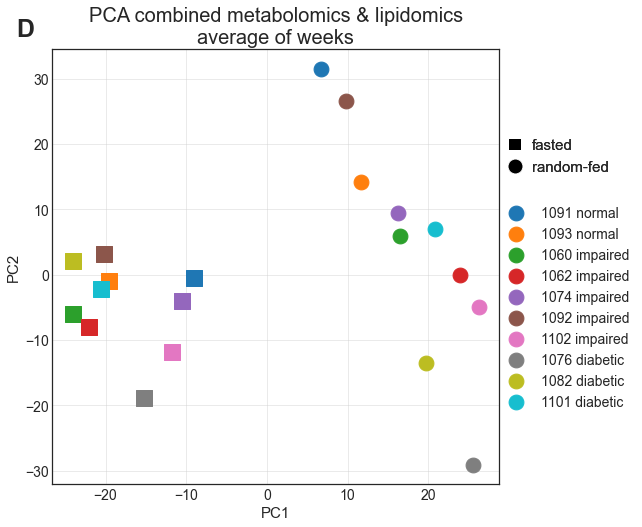

In [8]:
pc_to_plot_x = 1
pc_to_plot_y = 2

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC' + str(pc_to_plot_x), fontsize = 15)
ax.set_ylabel('PC' + str(pc_to_plot_y), fontsize = 15)
ax.set_title('PCA combined metabolomics & lipidomics\naverage of weeks', fontsize = 20)

markers = ['o', 's']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
          'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
# colors = [plt.get_cmap('Dark2')(i) for i in range(1, 11)]
handles = []
for rat_label, color in zip(animals_used, colors):
    for bg_type, marker in zip(['RBG', 'FBG'], markers):
        tolerance_type = animal_tol[rat_label]
        edge_color = None
        if tolerance_type == 'diabetic':
            edge_color = 'lightgray'
        elif tolerance_type == 'impaired':
            edge_color = 'darkgray'
        else: 
            edge_color = 'black'

        scatter_points = pca_data[(pca_data['gluc_tol'] == tolerance_type) & \
                                  (pca_data['animal'] == (rat_label)) & \
                                  (pca_data['bg_type'] == bg_type)].mean(axis=0)
        handle = ax.scatter(scatter_points['pc' + str(pc_to_plot_x)],
                            scatter_points['pc' + str(pc_to_plot_y)],
                            c = color,
                            marker=marker,
#                             edgecolors=edge_color,
#                             linewidths=3,              # linewidths is stroke size of marker outline
                            s = (250 if marker == 's' else 220),
                            )
#         # Annotate the plot with letter for Diabetic, Normal, Impaired
#         ax.annotate(tolerance_type[0].upper(), 
#                     xy=(scatter_points['pc1']-0.5, scatter_points['pc2']-0.7), 
#                     fontsize=20,
#                     color='black')
        # define the text label for the data handle for the legend:
#         gluc_tol = ap[ap['animal'] == rat_label]['glucose_tolerance'].values[0]
        handle.set_label(str(rat_label) + ' ' + tolerance_type )
        handles.append(handle)
# ax.legend(['RBG sample', 'FBG sample'],)
ax.grid(alpha=0.5)
legend_labels = []
for animal in animals_used:
    animal_data = ap[ap.index == animal]
    gluc_tol = animal_data['glucose_tolerance'].values[0]
    label = str(animal) + ' ' + gluc_tol
    legend_labels.append(label)
    
# Sort legend_labels based on normal/impaired/diabetic substring
# legend_labels.sort(key = lambda x: x.split(' ')[1])
handles, labels = ax.get_legend_handles_labels()
# print(handles, labels)
legend = ax.legend(handles[::2], labels[::2], loc=(0.995, 0.16), fontsize=14)
# legend = ax.legend(labels=legend_labels, loc=(1.01, 0.7))
legend2 = ax.legend(handles=[mpatches.Rectangle(xy=(0, 0), width=1, height=1, color='black', label='fasted', ),
                   Line2D([0], [0], marker='o', color='white', label='random-fed', 
                          markerfacecolor='black', markersize=15)], loc=(1.01, 0.7), fontsize=15, handlelength=0.7)
ax.add_artist(legend)
ax.add_artist(legend2)
# ax.legend(handles=[mpatches.Rectangle(xy=(0, 0), width=1, height=1, color='black', label='FBG'),
#                    mpatches.Circle(xy=(0, 0), color='black', label='RBG')], loc=(1.01, 0.98))
ax.text(-0.08, 1.03, "D", transform=ax.transAxes, fontsize=25, weight='bold')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(f'PC{pc_to_plot_x}', fontsize=15)
plt.ylabel(f'PC{pc_to_plot_y}', fontsize=15)

# plt.tight_layout()
# plt.savefig(r'..\reports\figures\3-5-1\multiomics_PCA_week_average.png', bbox_inches='tight')
# plt.savefig(r'..\reports\figures\3-5-1\multiomics_PCA_week_average.svg', bbox_inches='tight')

C:\Users\bjanderson23\anaconda3\lib\site-packages\ipykernel_launcher.py:28: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


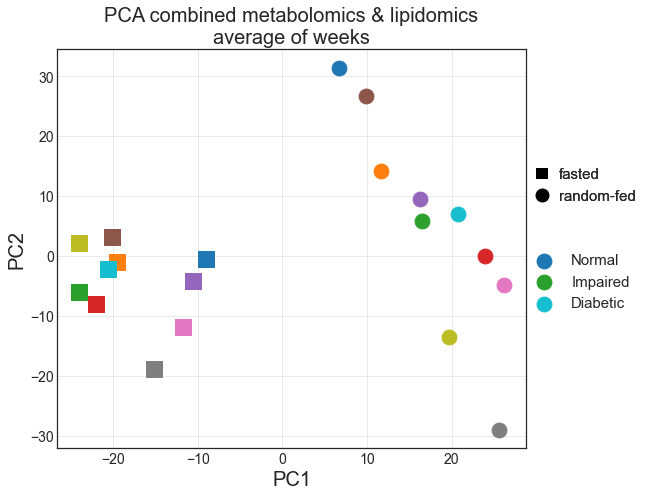

In [14]:
pc_to_plot_x = 1
pc_to_plot_y = 2

fig = plt.figure(figsize = (7.5, 7))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC' + str(pc_to_plot_x), fontsize = 15)
ax.set_ylabel('PC' + str(pc_to_plot_y), fontsize = 15)
ax.set_title('PCA combined metabolomics & lipidomics\naverage of weeks', fontsize = 20)

markers = ['o', 's']
# colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
#           'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
# colors = [plt.get_cmap('Dark2')(i) for i in range(1, 11)]
handles = []
for rat_label, color in zip(animals_used, colors):
    for bg_type, marker in zip(['RBG', 'FBG'], markers):
        tolerance_type = animal_tol[rat_label]
        edge_color = None
        if tolerance_type == 'diabetic':
            edge_color = 'lightgray'
        elif tolerance_type == 'impaired':
            edge_color = 'darkgray'
        else: 
            edge_color = 'black'

        scatter_points = pca_data[(pca_data['gluc_tol'] == tolerance_type) & \
                                  (pca_data['animal'] == (rat_label)) & \
                                  (pca_data['bg_type'] == bg_type)].mean(axis=0)
        handle = ax.scatter(scatter_points['pc' + str(pc_to_plot_x)],
                            scatter_points['pc' + str(pc_to_plot_y)],
                            color=color,
                            marker=marker,
#                             edgecolors=edge_color,
#                             linewidths=3,              # linewidths is stroke size of marker outline
                            s = (250 if marker == 's' else 220),
                            )
#         # Annotate the plot with letter for Diabetic, Normal, Impaired
#         ax.annotate(tolerance_type[0].upper(), 
#                     xy=(scatter_points['pc1']-0.5, scatter_points['pc2']-0.7), 
#                     fontsize=20,
#                     color='black')
        # define the text label for the data handle for the legend:
#         gluc_tol = ap[ap['animal'] == rat_label]['glucose_tolerance'].values[0]
        handle.set_label(str(rat_label) + ' ' + tolerance_type )
        handles.append(handle)
# ax.legend(['RBG sample', 'FBG sample'],)
ax.grid(alpha=0.5)
legend_labels = []
for animal in animals_used:
    animal_data = ap[ap.index == animal]
    gluc_tol = animal_data['glucose_tolerance'].values[0]
    label = str(animal) + ' ' + gluc_tol
    legend_labels.append(label)
    
# Sort legend_labels based on normal/impaired/diabetic substring
# legend_labels.sort(key = lambda x: x.split(' ')[1])
handles, labels = ax.get_legend_handles_labels()
# print(handles, labels)

gluc_tol_handles = [handles[0]] + [handles[4]] + [handles[18]]

# legend = ax.legend(handles[::2], labels[::2], loc=(0.995, 0.16), fontsize=14)
legend = ax.legend(gluc_tol_handles, ['Normal', 'Impaired', 'Diabetic'], loc=(0.995, 0.33), fontsize=15)

# legend = ax.legend(labels=legend_labels, loc=(1.01, 0.7))
legend2 = ax.legend(handles=[mpatches.Rectangle(xy=(0, 0), width=1, height=1, color='black', label='fasted', ),
                   Line2D([0], [0], marker='o', color='white', label='random-fed', 
                          markerfacecolor='black', markersize=15)], loc=(1.01, 0.6), fontsize=15, handlelength=0.7)
ax.add_artist(legend)
ax.add_artist(legend2)
# ax.legend(handles=[mpatches.Rectangle(xy=(0, 0), width=1, height=1, color='black', label='FBG'),
#                    mpatches.Circle(xy=(0, 0), color='black', label='RBG')], loc=(1.01, 0.98))
# ax.text(-0.08, 1.03, "D", transform=ax.transAxes, fontsize=25, weight='bold')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(f'PC{pc_to_plot_x}', fontsize=20)
plt.ylabel(f'PC{pc_to_plot_y}', fontsize=20)

plt.tight_layout()
# plt.savefig(r'..\reports\figures\3-5-1\PCA_week_average_NID.png', bbox_inches='tight')
# plt.savefig(r'..\reports\figures\3-5-1\PCA_week_average_NID.svg', bbox_inches='tight')

,animal,bg_type,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,...,pc52,pc53,pc54,pc55,pc56,pc57,pc58,pc59,pc60,week
0,1060,FBG,-24.040622,-6.055139,2.564570,2.626976,-1.786372,1.136620,-3.062446,3.596152,...,0.156983,-0.529438,0.545373,0.815283,0.320498,-0.688187,-0.242418,1.123832,8.895736e-15,9.0
1,1060,RBG,16.490533,5.846419,8.256286,-0.238440,-7.100018,7.543600,3.205590,-4.042878,...,0.372711,-0.000588,-0.056080,0.014083,-0.974865,0.246610,0.953826,-0.720639,8.895736e-15,9.0
2,1062,FBG,-21.994084,-7.970640,2.247905,3.089305,-2.165022,0.663189,1.439869,-1.251966,...,0.690521,0.831028,0.546673,0.277746,-0.232282,-0.091742,0.189093,-0.702255,8.895736e-15,9.0
3,1062,RBG,23.941660,-0.046311,-3.930604,-3.163164,-4.834572,-1.277288,0.482274,-0.660858,...,-0.592326,-0.964895,-0.571566,0.415800,0.469892,-0.502409,0.470346,-0.195708,8.895736e-15,9.0
4,1074,FBG,-10.557417,-4.101264,-6.101550,-2.794628,0.708838,0.286992,2.884132,-2.329401,...,-0.347712,0.640548,-0.031721,-1.419011,0.431456,2.039353,0.891508,-0.144778,8.895736e-15,9.0
5,1074,RBG,16.204998,9.451686,5.027854,4.999334,-1.185995,1.772518,4.348438,2.335197,...,1.235496,0.355923,0.682569,-0.121495,-0.316871,-0.674888,-1.133496,0.651836,8.895736e-15,9.0
6,1076,FBG,-15.176701,-18.935141,10.422108,8.558831,-4.759777,1.435121,1.270711,-5.954846,...,0.474613,-0.957896,0.342886,-0.521336,-0.971446,-0.418111,0.312304,0.462860,8.895736e-15,9.0
7,1076,RBG,25.524173,-29.060829,-2.044018,8.931908,1.360019,-1.298069,-2.313153,-0.148582,...,0.013340,0.488328,-0.490236,0.737993,1.779568,0.003241,-0.375583,-0.682753,8.895736e-15,9.0
8,1082,FBG,-24.063283,2.158877,-2.978820,-4.334404,-13.446726,4.180759,-1.677293,3.845424,...,-1.643572,-0.199830,0.087957,-0.393116,0.247242,-0.078275,-0.246954,0.294959,8.895736e-15,9.0
9,1082,RBG,19.678855,-13.486969,-1.024061,9.986677,-1.557343,-3.501500,3.972539,3.643233,...,0.238176,0.528826,-0.066779,-0.367432,-0.874322,0.488711,-0.706889,-0.101361,8.895736e-15,9.0


In [137]:
# Draw confidence intervals around data: 
# From https://stackoverflow.com/a/25022642

def make_ci(x, y, std=2, **kwargs):
    cov = np.cov(x, y)
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals = vals[order]
    vecs = vecs[:, order]
    theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    w, h = 2 * std * np.sqrt(vals)
    ellipse = Ellipse(xy=(np.mean(x), np.mean(y)), width=w, height=h, angle=theta, 
                      **kwargs)
    return ellipse

# Make color lighter, from https://stackoverflow.com/a/60562502
import colorsys

def scale_lightness(rgb, scale_l):
    # convert rgb to hls
    h, l, s = colorsys.rgb_to_hls(*rgb)
    # manipulate h, l, s values and return as rgb
    return colorsys.hls_to_rgb(h, min(1, l * scale_l), s = s)

In [179]:
cleaner_pca_data = pca_data.groupby(['animal', 'bg_type'], as_index=False).mean()
cleaner_pca_data['gluc_tol'] = cleaner_pca_data.loc[:, 'animal'].map(ap['glucose_tolerance'])
cleaner_pca_data

,animal,bg_type,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,...,pc53,pc54,pc55,pc56,pc57,pc58,pc59,pc60,week,gluc_tol
0,1060,FBG,-24.040622,-6.055139,2.564570,2.626976,-1.786372,1.136620,-3.062446,3.596152,...,-0.529438,0.545373,0.815283,0.320498,-0.688187,-0.242418,1.123832,8.895736e-15,9.0,impaired
1,1060,RBG,16.490533,5.846419,8.256286,-0.238440,-7.100018,7.543600,3.205590,-4.042878,...,-0.000588,-0.056080,0.014083,-0.974865,0.246610,0.953826,-0.720639,8.895736e-15,9.0,impaired
2,1062,FBG,-21.994084,-7.970640,2.247905,3.089305,-2.165022,0.663189,1.439869,-1.251966,...,0.831028,0.546673,0.277746,-0.232282,-0.091742,0.189093,-0.702255,8.895736e-15,9.0,impaired
3,1062,RBG,23.941660,-0.046311,-3.930604,-3.163164,-4.834572,-1.277288,0.482274,-0.660858,...,-0.964895,-0.571566,0.415800,0.469892,-0.502409,0.470346,-0.195708,8.895736e-15,9.0,impaired
4,1074,FBG,-10.557417,-4.101264,-6.101550,-2.794628,0.708838,0.286992,2.884132,-2.329401,...,0.640548,-0.031721,-1.419011,0.431456,2.039353,0.891508,-0.144778,8.895736e-15,9.0,impaired
5,1074,RBG,16.204998,9.451686,5.027854,4.999334,-1.185995,1.772518,4.348438,2.335197,...,0.355923,0.682569,-0.121495,-0.316871,-0.674888,-1.133496,0.651836,8.895736e-15,9.0,impaired
6,1076,FBG,-15.176701,-18.935141,10.422108,8.558831,-4.759777,1.435121,1.270711,-5.954846,...,-0.957896,0.342886,-0.521336,-0.971446,-0.418111,0.312304,0.462860,8.895736e-15,9.0,diabetic
7,1076,RBG,25.524173,-29.060829,-2.044018,8.931908,1.360019,-1.298069,-2.313153,-0.148582,...,0.488328,-0.490236,0.737993,1.779568,0.003241,-0.375583,-0.682753,8.895736e-15,9.0,diabetic
8,1082,FBG,-24.063283,2.158877,-2.978820,-4.334404,-13.446726,4.180759,-1.677293,3.845424,...,-0.199830,0.087957,-0.393116,0.247242,-0.078275,-0.246954,0.294959,8.895736e-15,9.0,diabetic
9,1082,RBG,19.678855,-13.486969,-1.024061,9.986677,-1.557343,-3.501500,3.972539,3.643233,...,0.528826,-0.066779,-0.367432,-0.874322,0.488711,-0.706889,-0.101361,8.895736e-15,9.0,diabetic


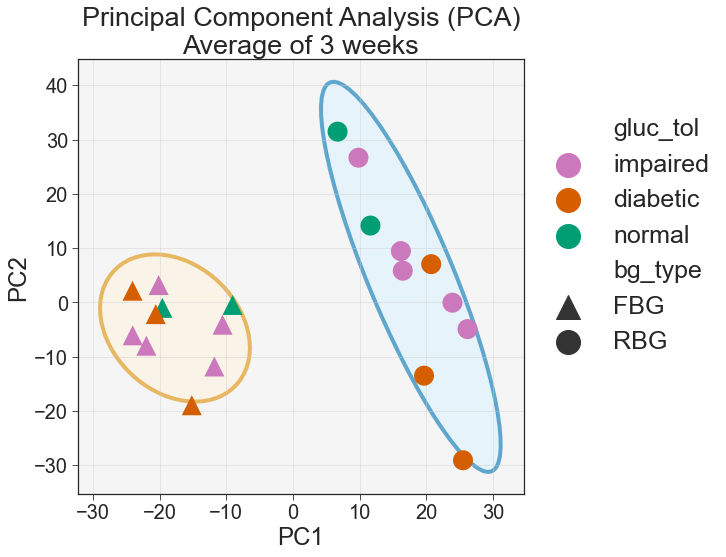

In [198]:
x_pc = 'pc1'
y_pc = 'pc2'

fig, ax = plt.subplots()
fig.set_size_inches(8, 8)
sns.scatterplot(
    data=cleaner_pca_data, x=x_pc, y=y_pc,
    hue='gluc_tol', palette=colors,
    style='bg_type', markers={'FBG': '^', 'RBG': 'o'},
#     size='bg_type', 
#     sizes={'FBG': 420, 'RBG': 350},
    s=400, 
    edgecolor='black', linewidth=0, 
    ax=ax,)
for bg_type in ['FBG', 'RBG']:
    df = cleaner_pca_data.loc[cleaner_pca_data['bg_type'] == bg_type]
    ci_ellipse = make_ci(x=df[x_pc], y=df[y_pc], 
                         edgecolor=colors[bg_type], 
                         facecolor=scale_lightness(colors[bg_type], (2.65 if bg_type == 'RBG' else 2.1)),
                         linewidth=4, alpha=0.6, zorder=0, 
#                          label=('Fed' if bg_type=='RBG' else 'Fasted'),
                        )
    ax.add_patch(ci_ellipse, )

plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.ylabel(y_pc.upper(), fontsize=24)
plt.xlabel(x_pc.upper(), fontsize=24)
plt.title('Principal Component Analysis (PCA)\nAverage of 3 weeks', fontsize=27)
plt.legend(loc=(1.02, 0.3), markerscale=4, fontsize=25,)
plt.grid(alpha=0.5)
ax.set_facecolor((0.96, 0.96, 0.96), )
# sns.despine()

plt.savefig(r'..\reports\figures\3-5-1\PCA_week_average_NID.png', 
            bbox_inches='tight', dpi=300,)
plt.savefig(r'..\reports\figures\3-5-1\PCA_week_average_NID.svg', 
            bbox_inches='tight', dpi=300)

ValueError: Could not interpret value `gluc_tol` for parameter `hue`

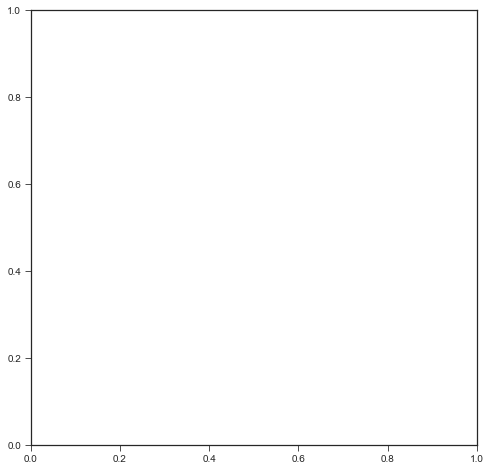

In [175]:
x_pc = 'pc1'
y_pc = 'pc2'

fig, ax = plt.subplots()
fig.set_size_inches(8, 8)
sns.scatterplot(
    data=cleaner_pca_data, x=x_pc, y=y_pc,
    hue='gluc_tol', palette=colors,
#     style='bg_type', markers={'FBG': '^', 'RBG': 'o'},
#     size='bg_type', sizes={'FBG': 420, 'RBG': 350},
    s=400, edgecolor='black', linewidth=0, 
    ax=ax,
)
for bg_type in ['FBG', 'RBG']:
    df = cleaner_pca_data.loc[cleaner_pca_data['bg_type'] == bg_type]
    ci_ellipse = make_ci(x=df[x_pc], y=df[y_pc], 
                         edgecolor=colors[bg_type], 
                         facecolor=scale_lightness(colors[bg_type], (2.65 if bg_type == 'RBG' else 2.1)),
                         linewidth=4, alpha=0.6, zorder=0, label=('Fed' if bg_type=='RBG' else 'Fasted'))
    ax.add_patch(ci_ellipse, )


plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.ylabel(y_pc.upper(), fontsize=24)
plt.xlabel(x_pc.upper(), fontsize=24)
plt.title('Principal Component Analysis (PCA)\nAverage of 3 weeks', fontsize=27)

plt.legend(loc=(1.02, 0.3), markerscale=3, fontsize=25,)
plt.grid(alpha=0.5)
# sns.despine()

# plt.savefig(r'..\reports\figures\3-5-1\PCA_week_average_NID.png', bbox_inches='tight')
# plt.savefig(r'..\reports\figures\3-5-1\PCA_week_average_NID.svg', bbox_inches='tight')